In [1]:
library(ArchR)
library(parallel)
library(Seurat)
library(stringr)
addArchRThreads(threads = 16) 
addArchRGenome('hg38')

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats

In [2]:
setwd('/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/benchmark/neurips/archr/')

In [3]:
proj <- ArchRProject(
  ArrowFiles = list.files(pattern = '*arrow')[1:length(list.files(pattern = '*arrow'))], 
  outputDirectory = "neurips",
  copyArrows = FALSE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

In [4]:
5

[1] 5

In [5]:
proj


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/benchmark/neurips/archr/neurips 
samples(14): s1d1 s1d2 ... s4d8 s4d9
sampleColData names(1): ArrowFiles
cellColData names(13): Sample TSSEnrichment ... nDiFrags BlacklistRatio
numberOfCells(1): 7725027
medianTSS(1): 0
medianFrags(1): 3

In [6]:
mapping <- fread('../phase2_to_new_bc_mapping.csv', header=TRUE)

In [7]:
#neurips cells
cellnames <- as.data.frame(str_split(mapping[['new_names']], '-', simplify=TRUE))
colnames(cellnames) <- c('barcode', 'sample', 'batch')

cellnames[cellnames[,3] == "",3] <- 's2d4'
cellnames[cellnames[,2] == "s2d4",2] <- '5'

cellnames[['full_barcode']] <- str_c(cellnames[['barcode']],cellnames[['batch']], sep='-')
cellnames[['orig_barcode']] <- mapping[['index']]

In [8]:
#archr cells
cellnames_archr <- as.data.frame(str_split(proj$cellNames, '#|-', simplify=TRUE))
colnames(cellnames_archr) <- c('batch', 'barcode', 'sample')

cellnames_archr[['full_barcode']] <- str_c(cellnames_archr[['barcode']],cellnames_archr[['batch']], sep='-')

In [9]:
proj$full_barcode <- cellnames_archr[['full_barcode']]

## Filter project

In [10]:
not_found <- cellnames[['full_barcode']][!(cellnames[['full_barcode']] %in% cellnames_archr[['full_barcode']])]

not_found <- as.data.frame(str_split(not_found, '#|-', simplify=TRUE))

colnames(not_found) <- c('barcode', 'batch')
table(not_found['batch'])


 s2d5 s3d10  s3d3  s3d7 
    2    13    24   144 

In [11]:
idx <- which(cellnames_archr[['full_barcode']] %in% cellnames[['full_barcode']])

In [12]:
length(proj$cellNames[idx])

[1] 62318

In [14]:
proj <- proj[proj$cellNames[idx]]

## Add cell type metadata

In [64]:
metadata <- fread('../metadata.csv')

In [65]:
metadata <- merge(metadata, mapping, by.x='V1', by.y='index', all=TRUE)

In [66]:
metadata <- merge(x=metadata, y=cellnames[,c('full_barcode', 'orig_barcode')], by.x='V1', by.y='orig_barcode')

In [70]:
head(metadata)

V1,nCount_peaks,atac_fragments,reads_in_peaks_frac,blacklist_fraction,nucleosome_signal,cell_type,pseudotime_order_ATAC,batch,pseudotime_order_GEX,is_train,size_factor,V1.y,phase2_names,new_names,full_barcode
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>,<int>,<chr>,<chr>,<chr>
AAACAGCCAAACCTAT-14-s3d7,14722,51696,0.2847803,0.0020377666,1.3553665,Proerythroblast,0.5678384,s3d7,0.4946356,TRUE,13957,37480,AAACAGCCAAACCTAT-14-s3d7,AAACAGCCAAACCTAT-14-s3d10,AAACAGCCAAACCTAT-s3d10
AAACAGCCAAAGCTCC-10-s3d10,9146,23658,0.3865923,0.0020774109,1.6002562,Proerythroblast,0.5342818,s3d10,0.3964623,TRUE,8635,32941,AAACAGCCAAAGCTCC-10-s3d10,AAACAGCCAAAGCTCC-10-s3d3,AAACAGCCAAAGCTCC-s3d3
AAACAGCCAAAGGCCA-12-s4d9,13414,12432,1.0789897,0.0014909796,0.4921875,Transitional B,NA,s4d9,NA,FALSE,13027,62466,AAACAGCCAAAGGCCA-12-s4d9,AAACAGCCAAAGGCCA-12-s4d9,AAACAGCCAAAGGCCA-s4d9
AAACAGCCAAATTCGT-13-s4d1,1384,1547,0.8946348,0.0000000000,0.9652510,CD16+ Mono,NA,s4d1,NA,FALSE,1315,44360,AAACAGCCAAATTCGT-13-s4d1,AAACAGCCAAATTCGT-13-s4d1,AAACAGCCAAATTCGT-s4d1
AAACAGCCAACACTTG-2-s1d2,6421,8963,0.7163896,0.0006229559,0.8327338,NK,NA,s1d2,NA,TRUE,6389,9537,AAACAGCCAACACTTG-2-s1d2,AAACAGCCAACACTTG-2-s1d2,AAACAGCCAACACTTG-s1d2
AAACAGCCAAGACTCC-10-s3d10,10835,20694,0.5235817,0.0016612829,1.5166436,CD8+ T naive,NA,s3d10,NA,TRUE,10515,30336,AAACAGCCAAGACTCC-10-s3d10,AAACAGCCAAGACTCC-10-s3d3,AAACAGCCAAGACTCC-s3d3


In [85]:
cellcoldata <- getCellColData(proj)

In [93]:
cellcoldata <- merge(cellcoldata, metadata, by='full_barcode', all.x=TRUE, sort = F)

In [99]:
proj <- addCellColData(proj, data=cellcoldata$cell_type, name='cell_type', cells = proj$cellNames, force=TRUE)

Overriding previous entry for cell_type



# Plot regions

In [133]:
peaks <- fread('../peaks.csv')

In [134]:
peaks <- data.frame(str_split(peaks$peaks, ':|-', simplify=TRUE))
colnames(peaks) <- c('chr', 'start', 'end')

In [140]:
regions = GRanges(seqnames = peaks$chr, ranges=IRanges(as.integer(peaks$start), as.integer(peaks$end)))

In [153]:
region_ofinterest = GRanges(seqnames='chr17', IRanges(22520971-10000, 22521869+10000))

In [154]:
markerGenes  <- c(
    "CD34", #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1" #B-Cell Trajectory
    #"CD14", #Monocytes
   # "CD3D", "CD8A", "TBX21", "IL7R" #TCells
  )

p <- plotBrowserTrack(
    ArchRProj = proj, 
    region=region_ofinterest,
    groupBy = "cell_type", 
    features=regions,
    #geneSymbol=markerGenes, 
    upstream = 10000,
    downstream = 10000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-3ad073d840a5e-Date-2022-07-22_Time-16-33-19.log
If there is an issue, please report to github with logFile!

2022-07-22 16:33:21 : Validating Region, 0.027 mins elapsed.

2022-07-22 16:33:21 : Adding Bulk Tracks (1 of 1), 0.027 mins elapsed.

Length of unique values greater than palette, interpolating..

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-07-22 16:33:30 : Adding Feature Tracks (1 of 1), 0.167 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-07-22 16:33:30 : Adding Gene Tracks (1 of 1), 0.168 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-07-22 16:33:30 : Plotting, 0.172 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-3ad073d840a5e-Date-2022-07-22_Time-16-33-19.log



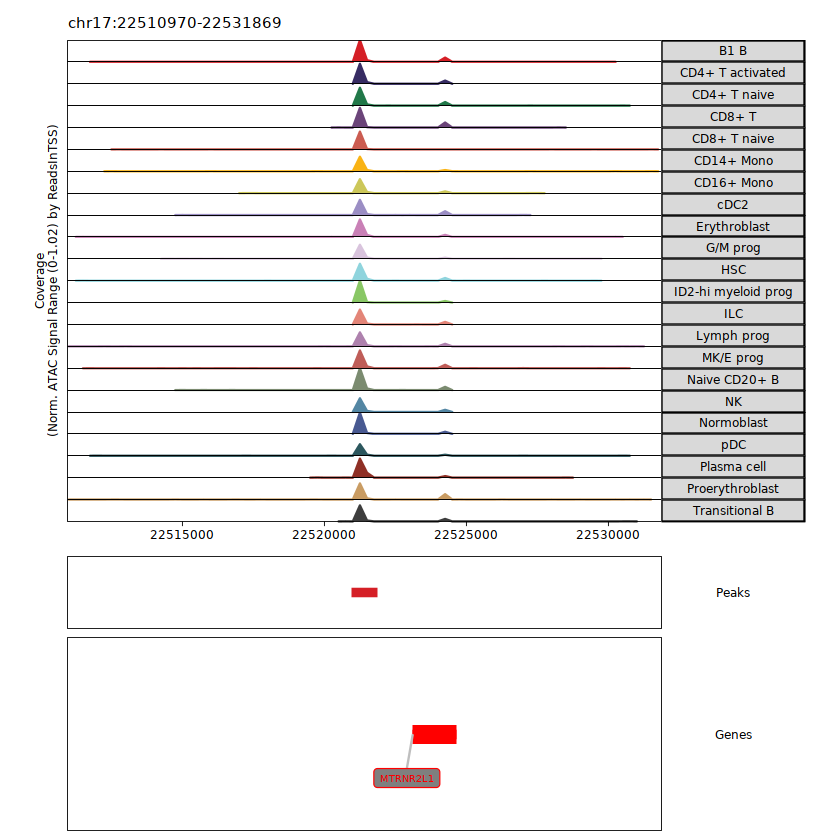

In [156]:
grid::grid.newpage()
grid::grid.draw(p)

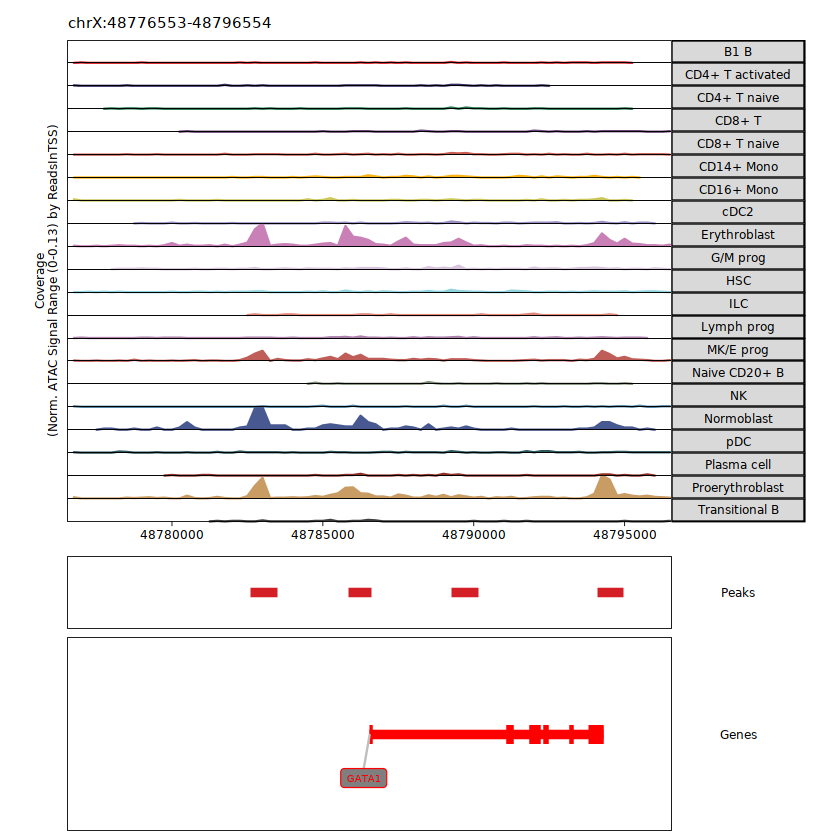

In [146]:
grid::grid.newpage()
grid::grid.draw(p$GATA1)

# Dimensionality reduction

In [41]:
proj <- addIterativeLSI(ArchRProj = proj, useMatrix = "TileMatrix", name = "IterativeLSI")

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-3ad07131d7a30-Date-2022-07-22_Time-15-27-20.log
If there is an issue, please report to github with logFile!

2022-07-22 15:27:39 : Computing Total Across All Features, 0.243 mins elapsed.

2022-07-22 15:27:53 : Computing Top Features, 0.468 mins elapsed.

###########
2022-07-22 15:27:57 : Running LSI (1 of 2) on Top Features, 0.54 mins elapsed.
###########

2022-07-22 15:27:57 : Sampling Cells (N = 10006) for Estimated LSI, 0.541 mins elapsed.

2022-07-22 15:27:57 : Creating Sampled Partial Matrix, 0.542 mins elapsed.

2022-07-22 15:28:37 : Computing Estimated LSI (projectAll = FALSE), 1.198 mins elapsed.

2022-07-22 15:30:08 : Identifying Clusters, 2.726 mins elapsed.

2022-07-22 15:30:24 : Identified 6 Clusters, 2.991 mins elapsed.

2022-07-22 15:30:24 : Saving LSI Iteration, 2.991 mins elapsed.

2022-07-22 15:30:53 : Creating Cluster Matrix on the total Group Features, 3.468 mins elapsed.

2022-07-22 15:34:03 : C

In [42]:
proj <- addUMAP(ArchRProj = proj, reducedDims = "IterativeLSI")

15:38:16 UMAP embedding parameters a = 0.7669 b = 1.223

15:38:16 Read 62318 rows and found 30 numeric columns

15:38:16 Using Annoy for neighbor search, n_neighbors = 40

15:38:16 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:38:23 Writing NN index file to temp file /tmp/RtmpRBq2C2/file3ad07698fff9c

15:38:23 Searching Annoy index using 48 threads, search_k = 4000

15:38:33 Annoy recall = 100%

15:38:35 Commencing smooth kNN distance calibration using 48 threads

15:38:40 Initializing from normalized Laplacian + noise

15:38:48 Commencing optimization for 200 epochs, with 3774408 positive edges

15:40:14 Optimization finished

15:40:14 Creating temp model dir /tmp/RtmpRBq2C2/dir3ad0750d6e087

15:40:14 Creating dir /tmp/RtmpRBq2C2/dir3ad0750d6e087

15:40:20 Changi

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-3ad07423e82ed-Date-2022-07-22_Time-16-07-19.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
Length of unique values greater than palette, interpolating..



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-3ad07423e82ed-Date-2022-07-22_Time-16-07-19.log



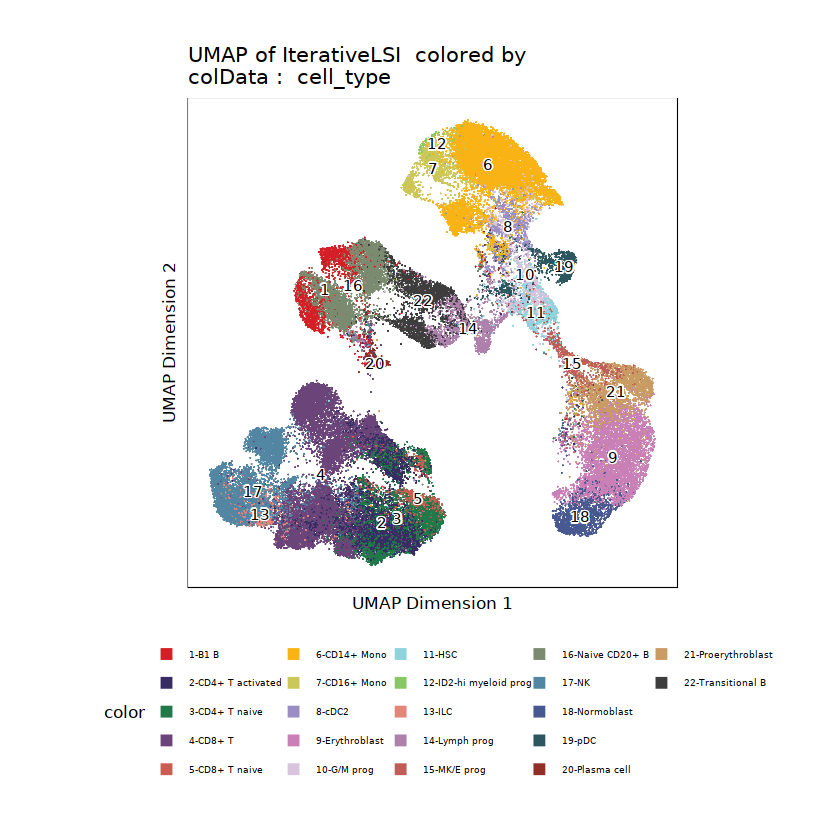

In [104]:
p1 <- plotEmbedding(ArchRProj = proj, embedding = "UMAP", name='cell_type', colorBy="cellColData")
p1